In [3]:
import file_path as fp
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import math
import collections
# import os
# from tensorflow.contrib.tensorboard.plugins import projector

In [98]:
input_data = pd.read_csv(fp.csv_folder+"beauty_data_info_train_competition.csv")

for col in input_data.columns.values:
    print(col, ": unique values =", len(input_data[col].unique()), ", non-empty rows =", len(input_data.dropna(subset=[col])))
    
# convert floating points class types to integer. Empty class type is filled with -1
input_data[input_data.columns.values[3:]] = input_data[input_data.columns.values[3:]].fillna(-1.0).astype(int)

itemid : unique values = 286583 , non-empty rows = 286583
title : unique values = 206379 , non-empty rows = 286583
image_path : unique values = 286583 , non-empty rows = 286583
Benefits : unique values = 8 , non-empty rows = 113556
Brand : unique values = 300 , non-empty rows = 238128
Colour_group : unique values = 40 , non-empty rows = 121324
Product_texture : unique values = 10 , non-empty rows = 244295
Skin_type : unique values = 9 , non-empty rows = 58410


There are duplicated item titles. use the following code to list them
```python
freq_dict = dict()
for title in input_data.title.values:
  if title in freq_dict:
    freq_dict[title] += 1
  else:
    freq_dict[title] = 1
for k, v in freq_dict.items():
  if v > 1:
    print(k)
```

In [5]:
def is_phone_number(string):
  if len(string) <= 3:
    return False
  digit_count = 0
  for char in string:
    if char.isdigit():
      digit_count += 1
      
  if digit_count > 3:
    return True
  
  return False

In [6]:
vocab_sentence = list()
sentence_id = 0

for line in input_data.title.values:
  tokens = line.split()
  for token in tokens:
    # remove telephone numbers
    if len(token) == 1 and not token.isdigit():
      continue
    if is_phone_number(token):
      continue
      
    vocab_sentence.append((token, sentence_id))
  
  sentence_id += 1

vocabulary, sentence_id_map = list(zip(*vocab_sentence))
  
print('Data size', len(vocabulary))

Data size 2129823


In [88]:
import collections

vocabulary_size = 300

def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    index = dictionary.get(word, 0)
    if index == 0:  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary, vocabulary_size)
# del vocabulary  # Hint to reduce memory.
print('Most common words', count[1:6])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])
print("length of the dictionary: ", len(reverse_dictionary), "should be equal to", vocabulary_size)
print("least common words", count[-5:])

Most common words [('cream', 74436), ('powder', 62796), ('bb', 35959), ('cushion', 31834), ('bedak', 25287)]
Sample data [43, 0, 0, 0, 13, 118, 14, 21, 121, 32] ['nyx', 'UNK', 'UNK', 'UNK', 'natural', 'palette', 'etude', 'house', 'precious', 'mineral']
length of the dictionary:  300 should be equal to 300
least common words [('immortal', 1349), ('putih', 1345), ('ee', 1333), ('waterproof', 1327), ('12', 1323)]


In [89]:
# calculate Term Frequency - Inverse Term Frequency for most common words
known_word_set = set([word for word, _ in count[1:]])

term_freq = dict()
inverse_term_freq = dict()
term_document_count = dict()

for itemid, title in input_data[["itemid", "title"]].values:
  tokens = title.split()
  unique_tokens = set()
  for token in tokens:
    if token not in known_word_set:
      continue
    if (itemid, token) in term_freq:
      term_freq[(itemid, token)] += 1
    else:
      term_freq[(itemid, token)] = 1
    unique_tokens.add(token)
    
  for token in unique_tokens:
    if token in term_document_count:
      term_document_count[token] += 1
    else:
      term_document_count[token] = 1  

n_documents = len(input_data)
for token, count in term_document_count.items():
  inverse_term_freq[token] = math.log(n_documents / count)

# no word is repeated in each title
for k, v in term_freq.items():
  if v > 1:
    print(k)

In [90]:
data_index = 0
# new
# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
  if data_index + span > len(data):
      data_index = 0
  buffer.extend(data[data_index:data_index + span])
  data_index += span
  for i in range(batch_size // num_skips):
    context_words = [w for w in range(span) if w != skip_window]
    words_to_use = random.sample(context_words, num_skips)
    for j, context_word in enumerate(words_to_use):
      if sentence_id_map[data_index-span+skip_window] == sentence_id_map[data_index-span+context_word]:
        batch[i * num_skips + j] = buffer[skip_window]
        labels[i * num_skips + j, 0] = buffer[context_word]
      else:
        batch[i * num_skips + j] = 0
        labels[i * num_skips + j, 0] = 0
    if data_index == len(data):
      buffer.extend(data[0:span])
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=20, num_skips=2, skip_window=1)
print(input_data.title.head(2).values)
for i in range(20):
  print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

data_index = 0

['nyx sex bomb pallete natural palette'
 'etude house precious mineral any cushion pearl aura puff']
0 UNK -> 43 nyx
0 UNK -> 0 UNK
0 UNK -> 0 UNK
0 UNK -> 0 UNK
0 UNK -> 0 UNK
0 UNK -> 13 natural
13 natural -> 0 UNK
13 natural -> 118 palette
0 UNK -> 0 UNK
118 palette -> 13 natural
0 UNK -> 0 UNK
14 etude -> 21 house
21 house -> 14 etude
21 house -> 121 precious
121 precious -> 21 house
121 precious -> 32 mineral
32 mineral -> 121 precious
32 mineral -> 0 UNK
0 UNK -> 4 cushion
0 UNK -> 32 mineral


In [91]:
# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 32  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.
num_sampled = 64  # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

graph = tf.Graph()

with graph.as_default():

  # Input data.
  with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Look up embeddings for inputs.
  with tf.name_scope('embeddings'):
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

# Construct the variables for the NCE loss
  with tf.name_scope('weights'):
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size))
    )
  with tf.name_scope('biases'):
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  # Explanation of the meaning of NCE loss:
  #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
  with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

  # Add the loss value as a scalar to summary.
  tf.summary.scalar('loss', loss)

  # Construct the SGD optimizer using a learning rate of 1.0.
  with tf.name_scope('optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Merge all summaries.
  merged = tf.summary.merge_all()

  # Add variable initializer.
  init = tf.global_variables_initializer()

  # Create a saver.
#   saver = tf.train.Saver()

In [92]:
# Step 5: Begin training.
num_steps = min(40000, len(data) * 2 // batch_size) + 1
print("Steps to run:", num_steps)

with tf.Session(graph=graph) as session:
#   Open a writer to write summaries.
#   writer = tf.summary.FileWriter(fp.log_dir, session.graph)

  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in range(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips,
                                                skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # Define metadata variable.
    run_metadata = tf.RunMetadata()

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
    # Feed metadata variable to session for visualizing the graph in TensorBoard.
    _, summary, loss_val = session.run(
        [optimizer, merged, loss],
        feed_dict=feed_dict,
        run_metadata=run_metadata)
    average_loss += loss_val

    # Add returned summaries to writer in each step.
#     writer.add_summary(summary, step)
    # Add metadata to visualize the graph for the last run.
#     if step == (num_steps - 1):
#       writer.add_run_metadata(run_metadata, 'step%d' % step)

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
#     if step % 10000 == 0:
#       sim = similarity.eval()
#       for i in range(valid_size):
#         valid_word = reverse_dictionary[valid_examples[i]]
#         top_k = 8  # number of nearest neighbors
#         nearest = (-sim[i, :]).argsort()[1:top_k + 1]
#         log_str = 'Nearest to %s: %s' % (valid_word, ", ".join([reverse_dictionary[k] for k in nearest]))
#         print(log_str)
  
  sim = similarity.eval()
  for i in range(valid_size):
    valid_word = reverse_dictionary[valid_examples[i]]
    top_k = 8  # number of nearest neighbors
    nearest = (-sim[i, :]).argsort()[1:top_k + 1]
    log_str = 'Nearest to %s: %s' % (valid_word, ", ".join([reverse_dictionary[k] for k in nearest]))
    print(log_str)
  final_embeddings = normalized_embeddings.eval()

  # Write corresponding labels for the embeddings.
#   with open(fp.log_dir + '/metadata.tsv', 'w') as f:
#     for i in range(vocabulary_size):
#       f.write(reverse_dictionary[i] + '\n')

  # Save the model for checkpoints.
#   saver.save(session, os.path.join(fp.log_dir, 'model.ckpt'))

  # Create a configuration for visualizing embeddings with the labels in TensorBoard.
#   config = projector.ProjectorConfig()
#   embedding_conf = config.embeddings.add()
#   embedding_conf.tensor_name = embeddings.name
#   embedding_conf.metadata_path = os.path.join(fp.log_dir, 'metadata.tsv')
#   projector.visualize_embeddings(writer, config)

# writer.close()

Steps to run: 33279
Initialized
Average loss at step  0 :  99.59525299072266
Average loss at step  2000 :  4.2309084291458126
Average loss at step  4000 :  3.5545855650901794
Average loss at step  6000 :  3.4892854754924776
Average loss at step  8000 :  3.462581793785095
Average loss at step  10000 :  3.429742821455002
Average loss at step  12000 :  3.416178761124611
Average loss at step  14000 :  3.4187735735177993
Average loss at step  16000 :  3.402027748823166
Average loss at step  18000 :  3.3948455159664155
Average loss at step  20000 :  3.3986201990842817
Average loss at step  22000 :  3.3902109924554824
Average loss at step  24000 :  3.3901135890483856
Average loss at step  26000 :  3.3896187871694563
Average loss at step  28000 :  3.385052701830864
Average loss at step  30000 :  3.3610139957666396
Average loss at step  32000 :  3.057904744386673
Nearest to way: 2in1, makeup, exclusive, aloe, makeover, soft, unik, lightening
Nearest to nyx: purbasari, loreal, 3ce, revlon, focal

In [14]:
# Step 6: Visualize the embeddings.
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = min(500, vocabulary_size)
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]

[]

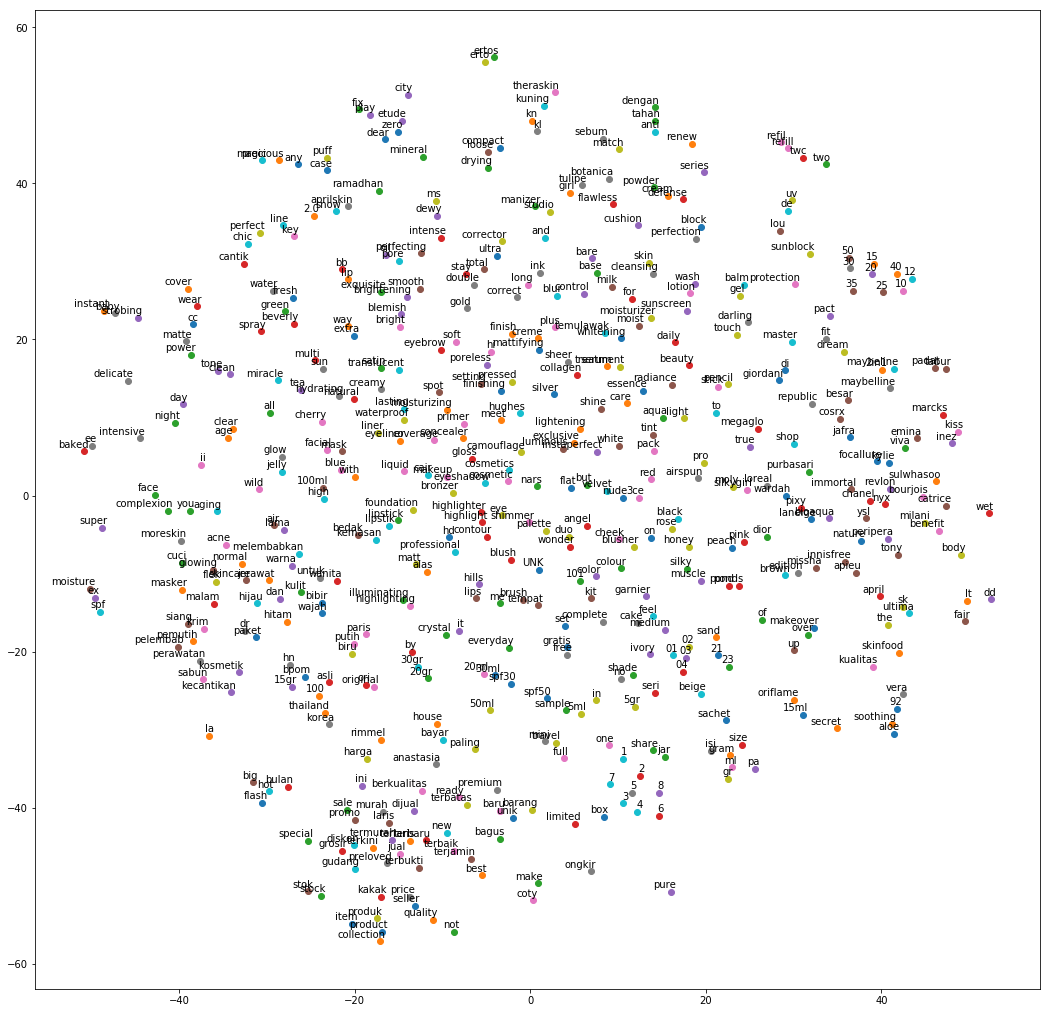

In [15]:
def plot_with_labels(low_dim_embs, labels):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')
  return plt

plot_with_labels(low_dim_embs, labels).plot()

Let's try to calculate the feature vector for each title using the the TF-IDF weighted word vector of known words

In [ ]:
def get_avg_title_vector(itemid, title):
  tokens = title.split()
  total_score = 0
  total_vec = np.zeros(embedding_size)
  for token in tokens:
    if token not in known_word_set:
      continue
    word_vec = final_embeddings[dictionary[token]]
    tf_idf_score = term_freq[(itemid, token)] * inverse_term_freq[token]
    total_score += tf_idf_score
    total_vec += word_vec * tf_idf_score
  
  if total_score == 0:
    return None
  return total_vec / total_score

input_data["title_vector"] = input_data.apply(lambda x: get_avg_title_vector(x.itemid, x.title), axis=1)

from sklearn.model_selection import train_test_split
train, test = train_test_split(input_data.dropna(subset=["title_vector"]), test_size=0.2, random_state=12345)

In [ ]:
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(X, true_y):
  labels = input_data[y_col].unique()
  labels.sort()
  
  print(clf)
  print("Vector size", embedding_size, "; Vocab size", vocabulary_size,
        "; Num skips", num_skips, "; Skip window", skip_window)
  print(labels)
  print(confusion_matrix(true_y, clf.predict(X), labels=labels))

we have too many empty labels that are trained as -1. Some of them might be true, while others can be false. let's try to address this by undersample empty labels

In [116]:
y_col = "Benefits"

reduction_factor = 3

valid_train = train[train[y_col] != -1]
empty_train = train[train[y_col] == -1]
sampled_empty_train = empty_train.sample(n=min(len(empty_train), len(valid_train)//reduction_factor), random_state=0)

new_train = pd.concat([valid_train, sampled_empty_train])

In [112]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
clf.fit(np.stack(new_train.title_vector.values), new_train[y_col])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [199]:
from sklearn.metrics import confusion_matrix
# vector size 64, 500 words, 1 skip, 2 skps
labels = input_data[y_col].unique()
labels.sort()

print(labels)
print(confusion_matrix(test[y_col].values, clf.predict(
      np.stack(test.title_vector.values)
      ),
     labels=labels))

[-1  0  1  2  3  4  5  6]
[[33253     0   520    17   445   166    23   173]
 [    1     1     0     0     0     0     0     0]
 [ 4589     0  3037     0    41    39     4    22]
 [  287     0     4   247     2     4     2     4]
 [ 3520     0    64     1  1931    10     2    18]
 [ 1246     0    32     0    16  1214     0     6]
 [  351     0     7     0     2     5   597     1]
 [ 1754     0    21     0     5     1     0  3625]]


In [71]:
print_confusion_matrix(np.stack(test.title_vector.values), test[y_col].values)

RandomForestClassifier ; Vector size 32 ; Vocab size 500 ; Num skips 2 ; Skip window 1
[-1  0  1  2  3  4  5  6]
[[32897     0   539    20   505   160    32   281]
 [    1     1     1     0     0     0     0     0]
 [ 4608     0  2863     1    53    30     4    63]
 [  278     0    12   262     2     3     2     3]
 [ 3621     0    64     1  1994    11     5    54]
 [ 1193     0    37     0     6  1243     0     3]
 [  344     0     7     0     1    13   653     4]
 [ 1627     0    19     0     7     2     0  3768]]


In [95]:
print_confusion_matrix(np.stack(test.title_vector.values), test[y_col].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Vector size 32 ; Vocab size 300 ; Num skips 2 ; Skip window 1
[-1  0  1  2  3  4  5  6]
[[33086     1   579    16   440   177    30   267]
 [    1     1     0     0     0     0     0     0]
 [ 4397     0  3049     1    43    32     6    58]
 [  271     0     6   272     2     6     1     5]
 [ 3549     0    65     4  1936    12     2    63]
 [ 1164     0    28     1     9  1248     1    14]
 [  336     0    16     0     2     4   621    14]
 [ 1632     0    29     0    10     1     0  3742]]


In [110]:
print_confusion_matrix(np.stack(test.title_vector.values), test[y_col].values)
# reduction factor 3

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Vector size 32 ; Vocab size 300 ; Num skips 2 ; Skip window 1
[-1  0  1  2  3  4  5  6]
[[22103     1  6422   118  3435   767    75  1675]
 [    1     1     0     0     0     0     0     0]
 [ 1459     0  5495     8   299    98     5   222]
 [  112     0    55   335    29     6     1    25]
 [ 1364     0   636    12  3386    36     5   192]
 [  549     0   245     2    94  1528     2    45]
 [  105     0   137     0    28     5   686    32]
 [  625     0   226     1    95     9     0  4458]]


In [113]:
print_confusion_matrix(np.stack(test.title_vector.values), test[y_col].values)
# reduction factor 4

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Vector size 32 ; Vocab size 300 ; Num skips 2 ; Skip window 1
[-1  0  1  2  3  4  5  6]
[[17356     1  9000   129  4785   919    84  2322]
 [    1     1     0     0     0     0     0     0]
 [  894     0  5929     7   394   103     5   254]
 [   68     0    76   344    45     6     2    22]
 [  905     0   844    13  3590    41     4   234]
 [  391     0   332     1   122  1560     2    57]
 [   67     0   169     0    32     7   681    37]
 [  406     0   292     2   124    11     0  4579]]


In [118]:
import xgboost as xgb

# dtrain = xgb.DMatrix(np.stack(train.title_vector.values))
# dtest = xgb.DMatrix(np.stack(test.title_vector.values))

clf = xgb.XGBClassifier(n_estimators=100, random_state=0, n_jobs=6, max_depth=6)
clf.fit(np.stack(new_train.title_vector.values), new_train[y_col])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=6, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [80]:
print_confusion_matrix(np.stack(test.title_vector.values), test[y_col].values)
# max_depth 3

XGBClassifier ; Vector size 32 ; Vocab size 500 ; Num skips 2 ; Skip window 1
[-1  0  1  2  3  4  5  6]
[[33758     0    74     1    54    85    42   420]
 [    3     0     0     0     0     0     0     0]
 [ 6377     0  1071     4    17    20    18   115]
 [  360     0    13   170     1     3    10     5]
 [ 5024     0    26     0   548     9    17   126]
 [ 1440     0     9     0     1  1015     5    12]
 [  490     0     5     1     2    19   494    11]
 [ 2465     0     5     1     5     0     4  2943]]


In [85]:
print_confusion_matrix(np.stack(test.title_vector.values), test[y_col].values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=6, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Vector size 32 ; Vocab size 500 ; Num skips 2 ; Skip window 1
[-1  0  1  2  3  4  5  6]
[[33517     0   248    10   179    77    35   368]
 [    3     0     0     0     0     0     0     0]
 [ 5519     0  1914     9    37    25    14   104]
 [  271     0    19   259     3     1     6     3]
 [ 4236     0    60     0  1332    10     6   106]
 [ 1301     0    19     1     2  1142     4    13]
 [  360     0     6     1     5     9   633     8]
 [ 1883     0    16     0     7     0     2  3515]]


In [97]:
print_confusion_matrix(np.stack(test.title_vector.values), test[y_col].values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=6, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Vector size 32 ; Vocab size 300 ; Num skips 2 ; Skip window 1
[-1  0  1  2  3  4  5  6]
[[33593     0   283    25   179    79    23   414]
 [    2     0     0     0     0     0     0     0]
 [ 5119     0  2280     6    30    13    10   128]
 [  252     0     9   285     3     3     4     7]
 [ 4007     0    71     5  1434     8     5   101]
 [ 1279     0    19     0    12  1139     4    12]
 [  334     0    20     1     0     2   617    19]
 [ 1864     0    46     0     8     1     3  3492]]


In [115]:
print_confusion_matrix(np.stack(test.title_vector.values), test[y_col].values)
#reduction factor 4

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=6, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Vector size 32 ; Vocab size 300 ; Num skips 2 ; Skip window 1
[-1  0  1  2  3  4  5  6]
[[16668     0  9829   177  4479   711   104  2628]
 [    2     0     0     0     0     0     0     0]
 [ 1045     0  5614    12   464    89    14   348]
 [   61     0    71   341    44    13     6    27]
 [ 1057     0  1022    17  3159    41    14   321]
 [  472     0   369     2   136  1412     6    68]
 [   59     0   164     2    33     7   681    47]
 [  500     0   379     3   149     6     7  4370]]


In [119]:
print_confusion_matrix(np.stack(test.title_vector.values), test[y_col].values)
#reduction factor 3

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=6, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Vector size 32 ; Vocab size 300 ; Num skips 2 ; Skip window 1
[-1  0  1  2  3  4  5  6]
[[21820     0  7023   144  3039   453    90  2027]
 [    2     0     0     0     0     0     0     0]
 [ 1703     0  5148    10   331    75    15   304]
 [  105     0    54   332    33    11     4    24]
 [ 1666     0   790    16  2820    26    12   301]
 [  655     0   280     2    99  1368     6    55]
 [  112     0   140     1    16     6   674    44]
 [  747     0   293     2   110     2     6  4254]]
